# Tutorial: Evidential Regression with Probly 

This notebook demonstrates how to use `probly` to transform a standard PyTorch Regression model into an Evidential Regression model capbale of quantifying its own uncertainty.

## 1. What is Evidential Regression? 

In standard deep learning for regression, a model predicts a single point of value (e.g., `y = 5.3`). This tells us nothing about the model's confidence. 

**Evidential Regression** is a method that reframes the problem. Instead of prediciting a single value, the model learns the parameters of a higher-order probability distribution (specifically, a **Normal-Inverse-Gamma** distribution).

This distribution *itself* represents a probability distribution *over possible regression outputs*. From these parameters, we can directly calculate not only the predicted value (the mean) but also the model's uncertainty.

## 2. Why Use it? Quantifying Uncertainty

The main advantage of this approach is its ability to distinguish between two types of uncertainty:

* **Aleatoric Uncertainty (Data Noise):** The uncertainty inherent in the data itself (e.g. sensor noise, natural variation). This is uncertainty that *cannot* be reduced, even with more data.
* **Epistemic Uncertainty (Model Uncertainty):** The uncertainty of the model due to a lack of training data. This uncertainty *can* be reduced by providing the model with more data in a specific region.

A standard model can't tell these apart. An evidential model can, which is crucial for safety-critical applications.

## 3. How It's Used: Making a Base Model 

Let's start with a standard PyTorch model for a simple regression task. It takes one input feature and is designed to predict a single point value.

In [ ]:
import matplotlib.pyplot as plt
import torch
from torch import nn


# 1. The Base Model (a simple point-predictor)
class SimpleRegressionModel(nn.Module):
    def __init__(self) -> None:
        """Initializes the simple regression model."""
        super().__init__()
        self.fc1 = nn.Linear(1, 64)  # 1 input feature
        self.activation = nn.ReLU()
        self.fc2 = nn.Linear(64, 1)  # 1 output value (the prediction)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """Forward pass of the model."""
        x = self.activation(self.fc1(x))
        x = self.fc2(x)
        return x


model = SimpleRegressionModel()
print("--- The Base Model (Before) ---")
print(model)

--- The Base Model (Before) ---
SimpleRegressionModel(
  (fc1): Linear(in_features=1, out_features=64, bias=True)
  (activation): ReLU()
  (fc2): Linear(in_features=64, out_features=1, bias=True)
)


This model is a "point predictor". For every input `x`, it returns exactly one inpout `y`.

**The Problem:** We have no idea *how certain* the model is about its prediction. If we ask it for a value far outside its training data, it will still just return a single number, no questions asked. 

## 4. The `probly` Solution

Instead of rewriting the entire model by hand, we can use `probly` to transform it automatically. We simply import our `evidential_regression` function and apply it.

In [2]:
# 2. Apply the Transformation
from probly.transformation.evidential.regression import evidential_regression

# This is the single line that does all the work
uncertainty_model = evidential_regression(model)

print("\n--- The Transformed Model (After) ---")
print(uncertainty_model)


--- The Transformed Model (After) ---
SimpleRegressionModel(
  (fc1): Linear(in_features=1, out_features=64, bias=True)
  (activation): ReLU()
  (fc2): NormalInverseGammaLinear()
)


## What happened? 

As you can see, `probly` automatically modified the model. It used `pytraverse` to traverse the model **backwards** (`TRAVERSE_REVERSED: True`) and identified the **last `nn.Linear` layer**.

**Before:**
`(fc2): nn.Linear(in_features=64, out_features=1)`

**After:**
`(fc2): NormalInverseGammaLinear()`

`probly` has swapped the layer! Although the printout doesn't show the `in_features` or `out_features`, the `NormalInverseGammaLinear` layer was correctly initialized.

This new layer no longer outputs a single value, but rather the **four parameters (gamma, nu, alpha, beta)** of a Normal-Inverse-Gamma distribution.

These parameters allow us to calculate both *aletoric* (data-based) and *epistemic* (model-based) uncertainty.

## 5. The Result: Visualizing Uncertainty

Now for the proof. We'll create a simple dataset (a sine wave with some noise) and have the model plot its uncertainty. 

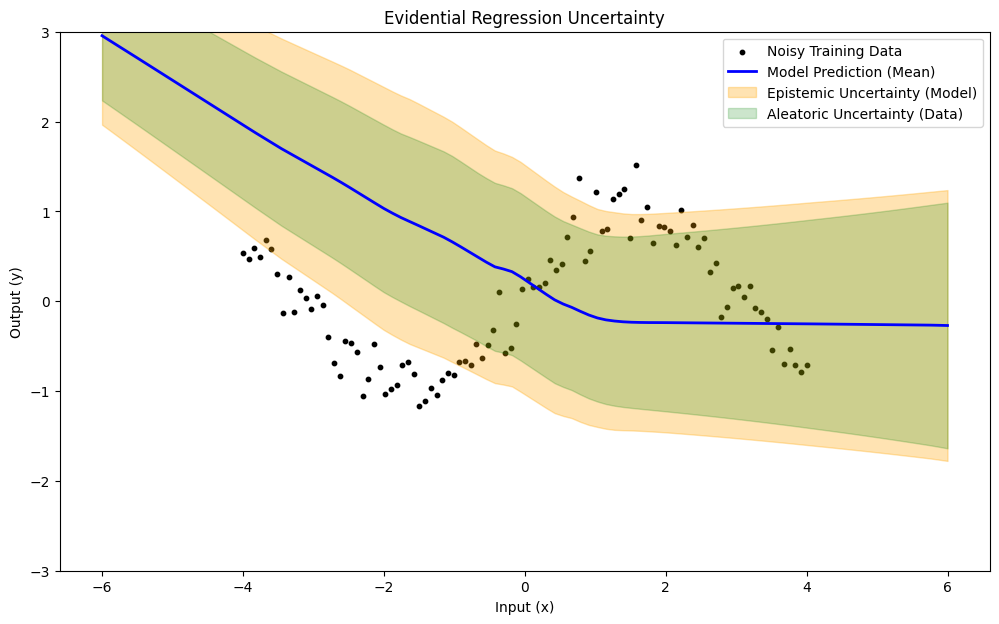

In [ ]:
# Create dummy data
torch.manual_seed(0)
X_train = torch.linspace(-4, 4, 100).view(-1, 1)
y_train = torch.sin(X_train) + torch.randn(100, 1) * 0.2
X_test = torch.linspace(-6, 6, 100).view(-1, 1)

# (In a real scenario, we would train this model.
# For this tutorial, we'll use the untrained model to
# highlight the high initial *epsitemic* (model) uncertainty.)

# IMPORTANT: The Evidential Layer behaves differently in train/eval mode.
uncertainty_model.train()

with torch.no_grad():
    # The model now outputs 4 parameters
    params = uncertainty_model(X_test)

    # Extract parameters (gamma, v, alpha, beta)
    gamma = params["gamma"]  # Predicted mean
    nu = params["nu"]  # Evidence for mean
    alpha = params["alpha"]  # Evidence for variance
    beta = params["beta"]  # Scale parameter

    mean_pred = gamma

    # Aleatoric uncertainty (data-noise)
    # Formula: Variance = beta / (alpha - 1)         # noqa: ERA001
    aleatoric_unc = torch.sqrt(beta / (alpha - 1))

    # Epistemic uncertainty (model-uncertainty)
    # Formula: Variance = beta / (nu * (alpha - 1))   # noqa: ERA001
    epistemic_unc = torch.sqrt(beta / (nu * (alpha - 1)))

# Plotting
plt.figure(figsize=(12, 7))
plt.scatter(X_train, y_train, label="Noisy Training Data", color="black", s=10)
plt.plot(X_test, mean_pred, label="Model Prediction (Mean)", color="blue", linewidth=2)

# Plot epistemic uncertainty (what the model doesn't know)
plt.fill_between(
    X_test.squeeze(),
    (mean_pred - epistemic_unc).squeeze(),
    (mean_pred + epistemic_unc).squeeze(),
    alpha=0.3,
    color="orange",
    label="Epistemic Uncertainty (Model)",
)

# Plot aleatoric uncertainty (noise in the data)
plt.fill_between(
    X_test.squeeze(),
    (mean_pred - aleatoric_unc).squeeze(),
    (mean_pred + aleatoric_unc).squeeze(),
    alpha=0.2,
    color="green",
    label="Aleatoric Uncertainty (Data)",
)

plt.title("Evidential Regression Uncertainty")
plt.xlabel("Input (x)")
plt.ylabel("Output (y)")
plt.legend()
plt.ylim(-3, 3)
plt.show()

## Conclusion 

As the plot clearly shows, our `probly` transformation was a success.

The original `SimpleRegressionModel` was "blind" to uncertainty; it could only produce a single prediction (the blue line). After our transformation, the new model is now "uncertainty-aware".

It can now display its own confidence, which we can clearly see as the **epistemic (orange)** and **aleatoric (green)** uncertainty bands. This ability to see is the main advantage of Evidential Regression and `probly` allowed us to build this model with just one line of code!